In [1]:
import sys; sys.path.insert(0, '../..')

import fenics as fa
import matplotlib.pyplot as plt
import mshr
import numpy as np
import pdb
import argparse
import jax
from collections import namedtuple

from src.nonlinear_stokes.nonlinear_stokes_common import (
    plot_solution,
    loss_fn,
    fenics_to_jax,
    SecondOrderTaylorLookup,
    error_on_coords,
    sample_params,
    sample_points,
)

from src.nonlinear_stokes.nonlinear_stokes_fenics import (
    solve_fenics,
    is_defined,
    parser
)

In [2]:
args = parser.parse_args("")
args = namedtuple("ArgsTuple", vars(args))(**vars(args))

In [3]:
params = sample_params(jax.random.PRNGKey(args.seed), args)
source_params, bc_params, per_hole_params, num_holes = params
print("params: ", params)

/usr/local/anaconda3/envs/dvvf/lib/python3.6/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


params:  (DeviceArray([0.4130522 , 0.25975317], dtype=float32), DeviceArray([3000.803], dtype=float32), DeviceArray([[ 0.04156993, -0.0613506 ,  0.47837767,  0.20494777,
               0.44709057],
             [-0.03926784, -0.11530625,  0.10562178,  0.4114218 ,
               0.35706055],
             [-0.04186818,  0.01709074,  0.18381561, -0.53561956,
               0.29799348]], dtype=float32), DeviceArray(1, dtype=int32))


In [4]:
u_p = solve_fenics(params)

In [5]:
points = sample_points(jax.random.PRNGKey(args.seed + 1), 1024, params)
points_on_inlet, points_on_walls, points_on_holes, points_in_domain = points

all_points = np.concatenate(points)

In [6]:
jax_fn = fenics_to_jax(u_p)

taylor = SecondOrderTaylorLookup(u_p, all_points)

In [7]:
for ii in range(10, 1, -1):
    x = points_in_domain[0] + 10**-ii
    print("val: ", jax_fn(x))
    print("grad: ", jax.grad(lambda z: jax_fn(z)[1])(x))

val:  [ 757.5868    -14.518968 1928.1127  ]
grad:  [-0. -0.]
val:  [ 757.5868    -14.518968 1928.1127  ]
grad:  [-0. -0.]
val:  [ 757.5868    -14.518968 1928.1127  ]
grad:  [-0. -0.]
val:  [ 757.5868    -14.518968 1928.1127  ]
grad:  [-0. -0.]
val:  [ 757.5868    -14.518968 1928.1127  ]
grad:  [-0. -0.]
val:  [ 757.5868    -14.518968 1928.1127  ]
grad:  [-0. -0.]
val:  [ 757.5868    -14.518968 1928.1127  ]
grad:  [-0. -0.]
val:  [ 761.2411    -14.721148 1920.1887  ]
grad:  [-0. -0.]
val:  [1056.755     -28.189093 1890.2019  ]
grad:  [-0. -0.]


In [8]:
jax.grad(lambda z: np.sum(jax.grad(lambda zz: np.sum(jax_fn(zz)))(z)))(points_in_domain[100])

DeviceArray([-0., -0.], dtype=float32)

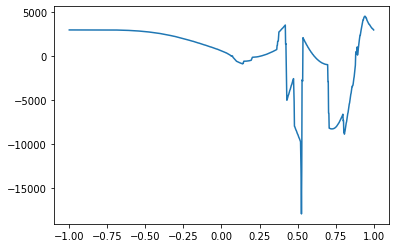

In [11]:
xvals = np.linspace(-1., 1., 1000)
yvals = np.zeros_like(xvals)
xy = np.array(list(zip(xvals, yvals)))
output = jax_fn(xy)
plt.plot(xvals, output[:, 0])

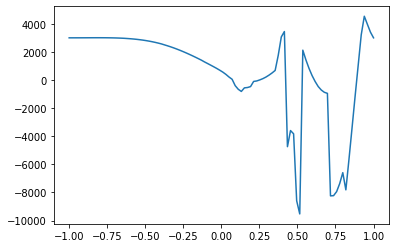

In [10]:
plt.plot(xvals, output[:, 0])

In [ ]:
xy

In [ ]:
points_in_domain[0]


In [ ]:
defined_walls = np.array([x for x in points_on_walls if is_defined(x, u_p)])
defined_holes = np.array([x for x in points_on_holes if is_defined(x, u_p)])

u_p.set_allow_extrapolation(True)
u_inlet = np.array([u_p(x) for x in points_on_inlet])
u_walls = np.array([u_p(x) for x in points_on_walls])
u_holes = np.array([u_p(x) for x in points_on_holes])
u_domain = np.array([u_p(x) for x in points_in_domain])
u_p.set_allow_extrapolation(False)

u_defined_walls = np.array([u_p(x) for x in defined_walls])
u_defined_holes = np.array([u_p(x) for x in defined_holes])

In [ ]:
def plot_mesh(u_p):
    fa.plot(
        u_p.function_space().mesh(),
        alpha=0.1
    )

def measure_fn_error(approx_fn, points, true_vals):
    error = np.linalg.norm(approx_fn(points) - true_vals, axis=1)
    rel_error = error / np.linalg.norm(true_vals, axis=1)
    print("mean abs err: ", np.mean(error))
    print("mean rel err: ", np.mean(rel_error))

    plt.figure(figsize=(4, 4))
    plt.title("Abs error distribution")
    plt.plot(np.arange(len(error))/len(error), np.sort(error))

    plt.figure(figsize=(4, 4))
    plt.title("Rel error distribution")
    plt.plot(np.arange(len(error))/len(error), np.sort(rel_error))

    plt.figure(figsize=(4, 4))
    plt.title("abs err")
    plot_mesh(u_p)
    clrs = plt.scatter(points[:, 0], points[:, 1], c=error)
    plt.colorbar(clrs)

    plt.figure(figsize=(4, 4))
    plt.title("rel err")
    plot_mesh(u_p)
    clrs = plt.scatter(points[:, 0], points[:, 1], c=rel_error)
    plt.colorbar(clrs)

    plt.show()

# jax_to_fenics (nearest neighbor interpolation)

In [ ]:
measure_fn_error(jax_fn, points_on_inlet, u_inlet)

In [ ]:
measure_fn_error(jax_fn, points_on_walls, u_walls)

In [ ]:
measure_fn_error(jax_fn, points_on_holes, u_holes)

In [ ]:
measure_fn_error(jax_fn, points_in_domain, u_domain)

In [ ]:
measure_fn_error(jax_fn, defined_walls, u_defined_walls)

In [ ]:
measure_fn_error(jax_fn, defined_holes, u_defined_holes)

# taylor expansion

In [ ]:
measure_fn_error(taylor, points_on_inlet, u_inlet)

In [ ]:
measure_fn_error(taylor, points_on_walls, u_walls)

In [ ]:
measure_fn_error(taylor, points_on_holes, u_holes)

In [ ]:
measure_fn_error(taylor, points_in_domain, u_domain)

In [ ]:
measure_fn_error(taylor, defined_walls, u_defined_walls)

In [ ]:
measure_fn_error(taylor, defined_holes, u_defined_holes)

# Investigating the loss function using Taylor


In [ ]:
from src.nonlinear_stokes.nonlinear_stokes_common import (
    loss_domain_fn,
    loss_inlet_fn,
    loss_noslip_fn
)

points = sample_points(jax.random.PRNGKey(args.seed + 1), 1024, params)
all_points = np.concatenate(points)
coords = np.array(u_p.function_space().tabulate_dof_coordinates())

In [ ]:
loss_fn(taylor, (points_on_inlet, points_on_walls, 
                 points_on_holes, points_in_domain),
        params)

In [ ]:
# Domain loss (which isn't enforced on boundaries)
# Just using fenics mesh
plot_mesh(u_p)
clrs = plt.scatter(
    coords[:, 0], coords[:, 1], 
    c=np.log(
        np.mean(
            loss_domain_fn(
                taylor, coords, params),
        axis=1)))
plt.colorbar(clrs)

In [ ]:
# Domain loss (which isn't enforced on boundaries)
# Using all points
plot_mesh(u_p)
clrs = plt.scatter(
    all_points[:, 0], all_points[:, 1], 
    c=np.log(
        np.mean(
            loss_domain_fn(
                taylor, all_points, params),
        axis=1)))
plt.colorbar(clrs)

In [ ]:
# Inlet loss (which is only enforced on inlet)
# Just using fenics mesh
plot_mesh(u_p)
clrs = plt.scatter(
    coords[:, 0], coords[:, 1], 
    c=np.log(
        np.mean(
            loss_inlet_fn(
                taylor, coords, params),
        axis=1)))
plt.colorbar(clrs)

In [ ]:
# Inlet loss (which is only enforced on inlet)
# Using all points
plot_mesh(u_p)
clrs = plt.scatter(
    all_points[:, 0], all_points[:, 1], 
    c=np.log(
        np.mean(
            loss_inlet_fn(
                taylor, all_points, params),
        axis=1)))
plt.colorbar(clrs)

In [ ]:
# Noslip loss (which is only enforced on walls/hole)
# Just using fenics mesh
plot_mesh(u_p)
clrs = plt.scatter(
    coords[:, 0], coords[:, 1], 
    c=np.log(
        np.mean(
            loss_noslip_fn(
                taylor, coords, params),
        axis=1)))
plt.colorbar(clrs)

In [ ]:
# Noslip loss (which is only enforced on walls/hole)
# Using all points
plot_mesh(u_p)
clrs = plt.scatter(
    all_points[:, 0], all_points[:, 1], 
    c=np.log(
        np.mean(
            loss_noslip_fn(
                taylor, all_points, params),
        axis=1)))
plt.colorbar(clrs)

# Investigate the loss fn using fenics_to_jax interpolation

In [ ]:
points = sample_points(jax.random.PRNGKey(args.seed + 1), 128, params)
points_on_inlet, points_on_walls, points_on_holes, points_in_domain = points

all_points = np.concatenate(points)

loss_fn(jax_fn, (points_on_inlet, points_on_walls, 
                 points_on_holes, points_in_domain),
        params)

In [ ]:
# Domain loss (which isn't enforced on boundaries)
# Just using fenics mesh
'''
plot_mesh(u_p)
clrs = plt.scatter(
    coords[:, 0], coords[:, 1], 
    c=np.log(
        np.mean(
            loss_domain_fn(
                jax_fn, coords, params),
        axis=1)))
plt.colorbar(clrs)
'''

In [ ]:
# Domain loss (which isn't enforced on boundaries)
# Using all points
plot_mesh(u_p)
clrs = plt.scatter(
    all_points[:, 0], all_points[:, 1], 
    c=np.log(
        np.mean(
            loss_domain_fn(
                jax_fn, all_points, params),
        axis=1)))
plt.colorbar(clrs)

In [ ]:
# Inlet loss (which is only enforced on inlet)
# Just using fenics mesh
plot_mesh(u_p)
clrs = plt.scatter(
    coords[:, 0], coords[:, 1], 
    c=np.log(
        np.mean(
            loss_inlet_fn(
                jax_fn, coords, params),
        axis=1)))
plt.colorbar(clrs)

In [ ]:
# Inlet loss (which is only enforced on inlet)
# Using all points
plot_mesh(u_p)
clrs = plt.scatter(
    all_points[:, 0], all_points[:, 1], 
    c=np.log(
        np.mean(
            loss_inlet_fn(
                jax_fn, all_points, params),
        axis=1)))
plt.colorbar(clrs)

In [ ]:
# Noslip loss (which is only enforced on walls/hole)
# Just using fenics mesh
plot_mesh(u_p)
clrs = plt.scatter(
    coords[:, 0], coords[:, 1], 
    c=np.log(
        np.mean(
            loss_noslip_fn(
                jax_fn, coords, params),
        axis=1)))
plt.colorbar(clrs)

In [ ]:
# Noslip loss (which is only enforced on walls/hole)
# Using all points
plot_mesh(u_p)
clrs = plt.scatter(
    all_points[:, 0], all_points[:, 1], 
    c=np.log(
        np.mean(
            loss_noslip_fn(
                jax_fn, all_points, params),
        axis=1)))
plt.colorbar(clrs)

In [ ]:
plot_mesh(u_p)
clrs = plt.scatter(
    points_on_holes[:, 0], points_on_holes[:, 1], 
    c=np.log(
        np.mean(
            loss_noslip_fn(
                jax_fn, points_on_holes, params),
        axis=1)))
plt.colorbar(clrs)

In [ ]:
jax.grad(jax_fn)(np.array([0.5, 0.5]))

In [ ]:
jax_fn(np.array([0.5, 0.5]))